In [ ]:
print(lrets*10000)

In [ ]:
from __future__ import division
import pandas as pd
import numpy as np
import argparse
import json
import csv
import sys
import os
import time
import datetime
from lib import bitmex
from lib.bitmex import BitMEX
from settings import API_BASE, API_KEY, API_SECRET
from numpy import mean,absolute 
import scipy as sp
from scipy.stats import *
from scipy.stats import skew, kurtosis
from scipy.signal import *
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
p = print
plt.rcParams['figure.figsize'] = [20, 10]

In [58]:
name = '1440_1m_30_Jun14.csv'
df1 = pd.read_csv(name)
n = 2

df_all = pd.DataFrame(df1)
df_all = pd.DataFrame(df_all.values[::-1], df_all.index, df_all.columns) # turn around data


close = df_all['close']
close_n = close.values[::n]
data = pd.DataFrame(close, dtype=float)
data_n= pd.DataFrame(close_n, dtype=float)
lrets = np.log(data/data.shift(1)).dropna()
lrets10k = lrets
lrets_n10k = np.log(data_n/data_n.shift(1)).dropna()*10000

In [ ]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = lrets_n10k
res_tup = _get_best_model(TS)

In [ ]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            0   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:               -273134.
Distribution:      Standardized Student's t   AIC:                           546283.
Method:                  Maximum Likelihood   BIC:                           546347.
                                              No. Observations:                21749
Date:                      Sat, Jun 16 2018   Df Residuals:                    21741
Time:                              14:25:28   Df Model:                            8
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

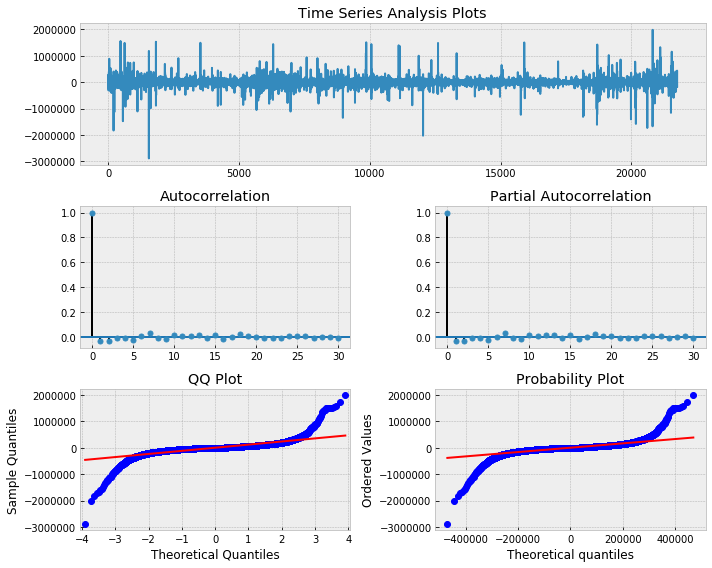

In [77]:
TS = lrets_n10k*10000
# Now we can fit the arch model using the best fit arima model parameters
order = [4,0,1]
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
p(res.summary())
tsplot(res.resid, lags=30)

In [ ]:
_ = tsplot(best_mdl.resid,lags=30)

In [ ]:
TS = lrets_n10k
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                    method='mle', trend='nc'
                )
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue
p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    


# Notice I've selected a specific time period to run this analysis

_ = tsplot(best_mdl.resid,lags=30)

In [ ]:
print(lrets)

In [ ]:
def dl1m(start, end,name):
    # Create connector
    connector = bitmex.BitMEX(base_url=API_BASE)

    # Do trade history query
    path = "trade/bucketed?binSize=1m&symbol=XBTUSD&columns=symbol%2C%20timestamp%2C%20close%2C%20high%2C%20low"
    count = 500  # max API will allow
    query = {
        'reverse': 'true',
        'start': start,
        'count': count,
        }

    csvwriter = None
    with open(name, 'w+') as f:
        while True:
            data = connector._curl_bitmex(path=path, verb="GET", query=query, timeout=5)
            if csvwriter is None:
                # csv requires dict keys
                if len(data) == 0:
                    break
                keys = sorted(data[0].keys())
                # Write to stdout
                csvwriter = csv.DictWriter(f, fieldnames=keys)
                csvwriter.writeheader()

            csvwriter.writerows(data)
            #data2 = pd.DataFrame
            query['start'] += count
            if query['start'] > end:
                break
            if len(data) < count:
                break